# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import xgboost

from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,LabelEncoder
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier,RandomForestClassifier

 
import warnings
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

# Reading Train and Test Data

In [2]:
df = pd.read_csv('train_new.csv')
test = pd.read_csv('test_new.csv')

ids = test['loan_id']
df.drop(columns='loan_id',inplace=True)
test.drop(columns='loan_id',inplace=True)

df.head()

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1
4,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1


# Imbalanced Data

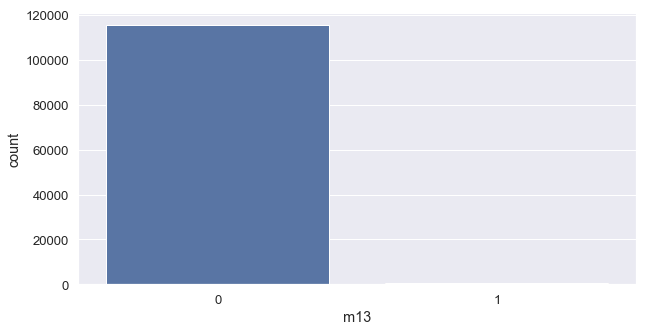

In [3]:
sns.set(font_scale=1.2)
plt.figure(figsize=(10,5))
sns.countplot(df['m13'])

In [4]:
loan_status_dist=df['m13'].value_counts()
print(loan_status_dist)
print('\nNon deliquent  (0) class {:0.2f}%'.format(100 *loan_status_dist[0] / (loan_status_dist[0]+loan_status_dist[1])))
print('Deliquent      (1) class {:0.2f}%'.format(100 *loan_status_dist[1] / (loan_status_dist[0]+loan_status_dist[1])))

0    115422
1    636   
Name: m13, dtype: int64

Non deliquent  (0) class 99.45%
Deliquent      (1) class 0.55%


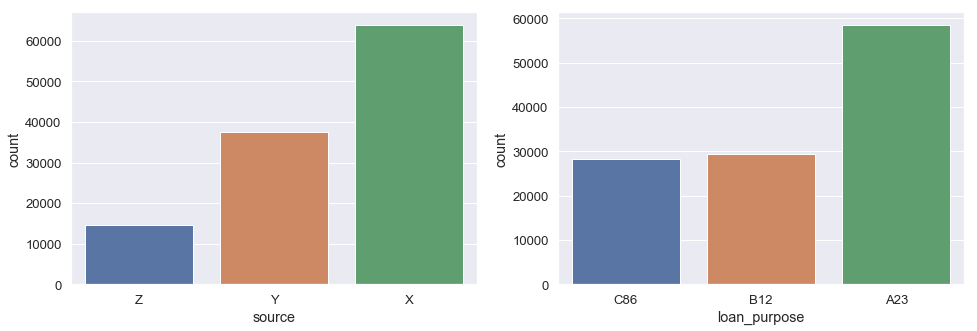

In [5]:
plt.figure(figsize=(16,5))

sns.set(font_scale=1.2)
plt.subplot(121)
sns.countplot(df['source'])

plt.subplot(122)
sns.countplot(df['loan_purpose'])

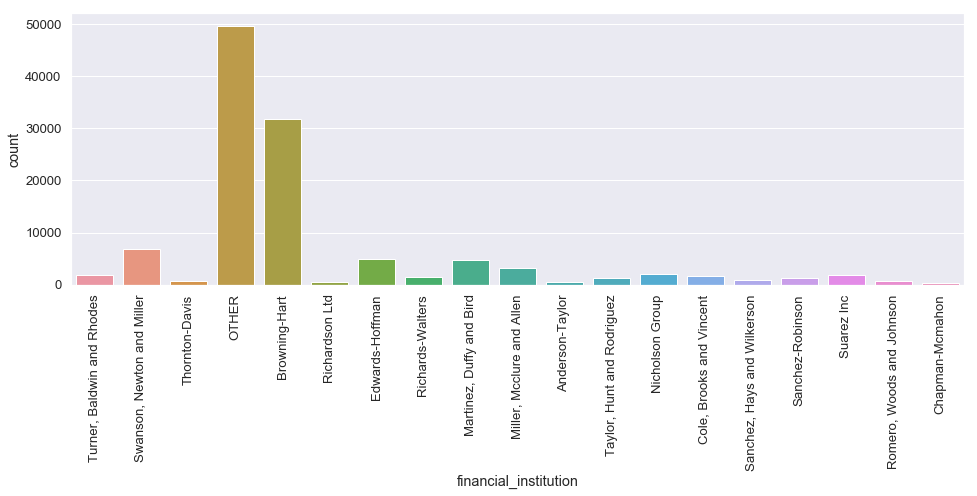

In [6]:
plt.figure(figsize=(16,5))
sns.countplot(df['financial_institution'])
plt.xticks(rotation=90);

# Feature Engineering

In [7]:
df['financial_institution'] = df['financial_institution'].apply(lambda x:x.lower())
test['financial_institution'] = test['financial_institution'].apply(lambda x:x.lower())

df['origination_month'] = df['origination_date'].map({'2012-01-01':1, '2012-02-01':2, '2012-03-01':3})
test['origination_month'] = test['origination_date'].map({'01/01/12':1, '01/02/12':2, '01/03/12':3})

df['firstpayment_month'] = df['first_payment_date'].map({'02/2012':2, '03/2012':3, '04/2012':4, '05/2012':5})
test['firstpayment_month'] = test['first_payment_date'].map({'Apr-12':4, 'Feb-12':2, 'Mar-12':3, 'May-12':5})

# df['orig_pay_gap'] = df['firstpayment_month'] - df['origination_month']
# test['orig_pay_gap'] = test['firstpayment_month'] - test['origination_month']

df.drop(columns=['origination_date','first_payment_date'],inplace=True)
test.drop(columns=['origination_date','first_payment_date'],inplace=True)

df['source']   = df['source'].map({'X':3,'Y':2,'Z':1})
test['source'] = test['source'].map({'X':3,'Y':2,'Z':1})

df['loan_purpose']   = df['loan_purpose'].map({'A23':1, 'B12':2, 'C86':3})
test['loan_purpose'] = test['loan_purpose'].map({'A23':1, 'B12':2, 'C86':3})

df['number_of_borrowers']=df['number_of_borrowers'].astype(int)
test['number_of_borrowers']=test['number_of_borrowers'].astype(int)

df['insurance_type']=df['insurance_type'].astype(int)
test['insurance_type']=test['insurance_type'].astype(int)


lab_enc = LabelEncoder()
df['financial_institution'] = lab_enc.fit_transform(df['financial_institution'])
test['financial_institution'] = lab_enc.transform(test['financial_institution'])

# df['total_credit_score'] = df['borrower_credit_score'] + df['co-borrower_credit_score']
# test['total_credit_score'] = test['borrower_credit_score'] + test['co-borrower_credit_score']

# df['loan_months'] = df['loan_term'].apply(lambda x:round(x/30))
# test['loan_months'] = test['loan_term'].apply(lambda x:round(x/30))

x=df.drop(columns='m13')
y=df['m13']

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=100,stratify=y)
print('Shape of x_train {} and y_train {}'.format(x_train.shape,y_train.shape))
print('Shape of x_test  {} and y_test {}'.format(x_test.shape,y_test.shape))

df.head()

Shape of x_train (87043, 27) and y_train (87043,)
Shape of x_test  (29015, 27) and y_test (29015,)


,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,origination_month,firstpayment_month
0,1,18,4.250,214000,360,95,1,22.0,694.0,3,30.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3,5
1,2,15,4.875,144000,360,72,1,44.0,697.0,2,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,3
2,1,17,3.250,366000,180,49,1,33.0,780.0,2,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3
3,3,8,4.750,135000,360,46,2,44.0,633.0,2,0.0,638.0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,4
4,3,8,4.750,124000,360,80,1,43.0,681.0,3,0.0,0.0,0,0,1,2,3,4,5,6,7,8,9,10,11,1,2,4


# Model Training

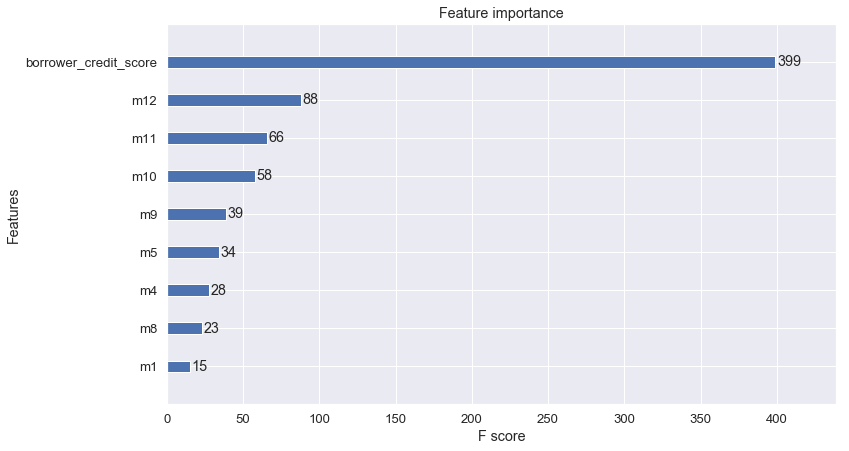

In [8]:
# these hyper-parameters are obtained by doing GridSearchCV
model=XGBClassifier(min_child_weight=5,max_depth=3,subsample=0.85,n_estimators=120,scale_pos_weight=3.8421052631578947)

# these 9 columns are obtained using Recursive Feature elimination along with 5 fold cross-validation
cols = ['m1','m4','m5','m8','m9','m10','m11','m12','borrower_credit_score']

model.fit(x[cols],y)

fig, ax = plt.subplots(figsize=(12, 7)) 
xgboost.plot_importance(model, ax=ax,height=0.3)

# Making predictions on test data

In [9]:
ans = pd.DataFrame({'loan_id':ids,'m13':pd.Series(model.predict(test[cols]))})
ans.to_csv('final_sol.csv',index=None)